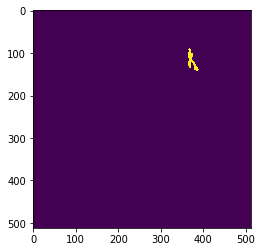

In [118]:
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage
import numpy as np

"load image data"
Img_Original =  io.imread( 'segmentation_g5000gy/mask_2_508.jpg') # Gray image, rgb images need pre-conversion
# cv2.dilate(Img_Original, np.ones((2,2)))
plt.imshow(Img_Original)
plt.show()

In [98]:
"Convert gray images to binary images using Otsu's method"
Img_Original[Img_Original == 255] = 1

In [78]:
def neighbours(x,y,image):

    "Return 8-neighbours of image point P1(x,y), in a clockwise order"

    img = image

    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1

    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5

                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours):

    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"

    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2

    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)


def zhangSuen(image):

    "the Zhang-Suen Thinning Algorithm"

    Image_Thinned = image.copy()  # deepcopy to protect the original image

    changing1 = changing2 = 1        #  the points to be removed (set as 0)

    while changing1 or changing2:   #  iterates until no further changes occur in the image

        # Step 1

        changing1 = []

        rows, columns = Image_Thinned.shape               # x for rows, y for columns

        for x in range(1, rows - 1):                     # No. of  rows

            for y in range(1, columns - 1):            # No. of columns

                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)

                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 

                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6

                    transitions(n) == 1 and    # Condition 2: S(P1)=1  

                    P2 * P4 * P6 == 0  and    # Condition 3   

                    P4 * P6 * P8 == 0):         # Condition 4

                    changing1.append((x,y))

        for x, y in changing1: 

            Image_Thinned[x][y] = 0

        # Step 2

        changing2 = []

        for x in range(1, rows - 1):

            for y in range(1, columns - 1):

                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)

                if (Image_Thinned[x][y] == 1   and        # Condition 0

                    2 <= sum(n) <= 6  and       # Condition 1

                    transitions(n) == 1 and      # Condition 2

                    P2 * P4 * P8 == 0 and       # Condition 3

                    P2 * P6 * P8 == 0):            # Condition 4

                    changing2.append((x,y))    

        for x, y in changing2: 

            Image_Thinned[x][y] = 0

    return Image_Thinned

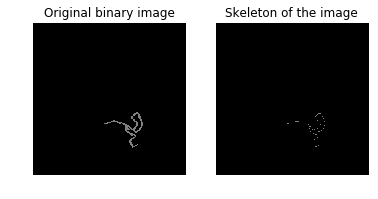

In [113]:
"Apply the algorithm on images"

BW_Skeleton = zhangSuen(Img_Original)

# BW_Skeleton = BW_Original

"Display the results"

fig, ax = plt.subplots(1, 2)

ax1, ax2 = ax.ravel()

ax1.imshow(Img_Original, cmap=plt.cm.gray)

ax1.set_title('Original binary image')

ax1.axis('off')

ax2.imshow(BW_Skeleton, cmap=plt.cm.gray)

ax2.set_title('Skeleton of the image')

ax2.axis('off')

plt.show()

In [114]:
import cv2

BW_Skeleton[BW_Skeleton >= 1] = 255
cv2.imshow("Original", Img_Original)
cv2.waitKey()
cv2.imshow("Skeleton", BW_Skeleton)
cv2.waitKey()

-1

In [35]:
BW_Skeleton[330:340,275:285]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [255, 255,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 255, 255, 255,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 255, 255, 255,   0],
       [  0,   0,   0,   0, 255,   0,   0,   0, 255, 255],
       [  0,   0,   0,   0,   0, 255,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=uint8)

In [115]:
import numpy as np
# Find row and column locations that are non-zero
(rows,cols) = np.nonzero(BW_Skeleton)

# Initialize empty list of co-ordinates
skel_coords = []

# For each non-zero pixel...
for (r,c) in zip(rows,cols):

    # Extract an 8-connected neighbourhood
    (col_neigh,row_neigh) = np.meshgrid(np.array([c-1,c,c+1]), np.array([r-1,r,r+1]))

    # Cast to int to index into image
    col_neigh = col_neigh.astype('int')
    row_neigh = row_neigh.astype('int')

    # Convert into a single 1D array and check for non-zero locations
    pix_neighbourhood = BW_Skeleton[row_neigh,col_neigh].ravel() != 0

    # If the number of non-zero locations equals 2, add this to 
    # our list of co-ordinates
    if np.sum(pix_neighbourhood) == 2:
        skel_coords.append((r,c))

In [116]:
# To show the co-ordinates of the end points, you can do:
print "".join(["(" + str(r) + "," + str(c) + ")\n" for (r,c) in skel_coords])

(333,279)
(334,281)
(335,279)
(336,280)
(339,238)
(410,350)



In [117]:
matrix = np.zeros((512,512))
for (r,c) in skel_coords:
    matrix[r,c] = 255

cv2.imshow("show", matrix)
cv2.waitKey()

-1